# Importing Repositories

In [86]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import holidays
from scipy import stats
warnings.filterwarnings("ignore")
sns.set_theme(style="darkgrid")
plt.rcParams['figure.figsize']=(20,10)

In [87]:
def missing_zero_values_table(df):
        ''''Takes a pandas dataframe and returns a statistics table that explains the missing and 
        zero values'''
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})
        mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
        mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df)
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Our selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
            "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")
    
        return mz_table

# Importing data files

## Paths for files

In [88]:
path_price = r'C:\Users\2836589S\OneDrive - University of Glasgow\Data\DayAheadPrices_12.1.D'
path_totalload = r'C:\Users\2836589S\OneDrive - University of Glasgow\Data\DayAheadTotalLoadForecast'
path_windsolar = r'C:\Users\2836589S\OneDrive - University of Glasgow\Data\DayAheadGenerationForecastForWindAndSolar_14.1.D'

## Price Timeseries Importing

In [89]:

df_price = pd.read_csv(r'C:\Users\2836589S\OneDrive - University of Glasgow\Data\Data Frames\price_timeseries_outliers.csv', 
parse_dates=['DateTime'])


In [90]:
df_price = df_price[['DateTime', 'Year', 'Month','Week', 'Day', 'Hour', 'Price', 'Outlier']]
df_price

,DateTime,Year,Month,Week,Day,Hour,Price,Outlier
0,2015-01-01 00:00:00,2015,1,1,3,0,0.00,N
1,2015-01-01 01:00:00,2015,1,1,3,1,0.00,N
2,2015-01-01 02:00:00,2015,1,1,3,2,0.00,N
3,2015-01-01 03:00:00,2015,1,1,3,3,0.00,N
4,2015-01-01 04:00:00,2015,1,1,3,4,0.00,N
...,...,...,...,...,...,...,...,...
52529,2020-12-31 18:00:00,2020,12,53,3,18,71.30,N
52530,2020-12-31 19:00:00,2020,12,53,3,19,61.04,N
52531,2020-12-31 20:00:00,2020,12,53,3,20,60.39,N
52532,2020-12-31 21:00:00,2020,12,53,3,21,57.96,N


## Wind and Solar Timeseries Importing

In [91]:
f_windsolar = glob.glob(path_windsolar + "/*.csv")
dwindsolar = [pd.read_csv(f, sep='\t', parse_dates=['DateTime']) for f in f_windsolar]

df_windsolar = pd.concat(dwindsolar)
df_windsolar = df_windsolar[df_windsolar['AreaCode'] == '10YGB----------A']
df_windsolar = df_windsolar[['DateTime', 'ProductionType', 'AggregatedGenerationForecast']]
df_windsolar.sort_values(by='DateTime', ascending=True)
df_windsolar.reset_index(drop=True, inplace=True)

In [92]:
df_windsolar

,DateTime,ProductionType,AggregatedGenerationForecast
0,2014-12-30 00:00:00,Solar,0.00
1,2014-12-30 01:00:00,Solar,0.00
2,2014-12-30 02:00:00,Solar,0.00
3,2014-12-30 03:00:00,Solar,0.00
4,2014-12-30 04:00:00,Solar,0.00
...,...,...,...
509107,2021-06-14 19:00:00,Wind Offshore,1563.23
509108,2021-06-14 20:00:00,Wind Offshore,1590.47
509109,2021-06-14 21:00:00,Wind Offshore,1574.14
509110,2021-06-14 22:00:00,Wind Offshore,1450.72


### Splitting the WindSolar Dataset into 3 Datasets per Solar, Wind Offshore, Wind Onshore

In [93]:
df_windsolar['ProductionType'].unique()

array(['Solar', 'Wind Offshore', 'Wind Onshore'], dtype=object)

In [94]:
df_solar = df_windsolar[df_windsolar['ProductionType'] == 'Solar']
df_solar.sort_values(by='DateTime', ascending=True)
df_solar.reset_index(drop=True, inplace=True)
df_solar.rename(columns={'AggregatedGenerationForecast':'SolarGeneration'}, inplace=True)
df_solar = df_solar[['DateTime','SolarGeneration']]
df_solar

,DateTime,SolarGeneration
0,2014-12-30 00:00:00,0.0
1,2014-12-30 01:00:00,0.0
2,2014-12-30 02:00:00,0.0
3,2014-12-30 03:00:00,0.0
4,2014-12-30 04:00:00,0.0
...,...,...
169699,2021-06-14 19:00:00,227.0
169700,2021-06-14 20:00:00,11.5
169701,2021-06-14 21:00:00,0.0
169702,2021-06-14 22:00:00,0.0


In [95]:
# # Taking of the outliers
# q1 , q3 = np.percentile(df_solar['SolarGeneration'], [25,75])
# iqr = q3 - q1
# ul = q3 + 1.5*iqr
# ll = q1 - 1.5*iqr
# df_solar = df_solar[(df_solar['SolarGeneration'] > ll) | (df_solar['SolarGeneration'] < ul) ]

In [96]:
df_wind_off = df_windsolar[df_windsolar['ProductionType'] == 'Wind Offshore']
df_wind_off.sort_values(by='DateTime', ascending=True)
df_wind_off.reset_index(drop=True, inplace=True)
df_wind_off.rename(columns={'AggregatedGenerationForecast':'WindOffGeneration'}, inplace=True)
df_wind_off = df_wind_off[['DateTime', 'WindOffGeneration']]
df_wind_off

,DateTime,WindOffGeneration
0,2014-12-30 00:00:00,996.58
1,2014-12-30 01:00:00,1059.20
2,2014-12-30 02:00:00,1123.27
3,2014-12-30 03:00:00,1177.54
4,2014-12-30 04:00:00,1188.21
...,...,...
169699,2021-06-14 19:00:00,1563.23
169700,2021-06-14 20:00:00,1590.47
169701,2021-06-14 21:00:00,1574.14
169702,2021-06-14 22:00:00,1450.72


In [97]:
# # Taking care of the outliers
# q1 , q3 = np.percentile(df_wind_off['WindOffGeneration'], [25,75])
# iqr = q3 - q1
# ul = q3 + 1.5*iqr
# ll = q1 - 1.5*iqr
# df_wind_off = df_wind_off[(df_wind_off['WindOffGeneration'] > ll) | (df_wind_off['WindOffGeneration']) ]

In [98]:
df_wind_on = df_windsolar[df_windsolar['ProductionType'] == 'Wind Onshore']
df_wind_on.sort_values(by='DateTime', ascending=True)
df_wind_on.reset_index(drop=True, inplace=True)
df_wind_on.rename(columns={'AggregatedGenerationForecast':'WindOnGeneration'}, inplace=True)
df_wind_on = df_wind_on[['DateTime','WindOnGeneration']]
df_wind_on

,DateTime,WindOnGeneration
0,2014-12-30 00:00:00,2363.80
1,2014-12-30 01:00:00,2413.88
2,2014-12-30 02:00:00,2450.75
3,2014-12-30 03:00:00,2500.78
4,2014-12-30 04:00:00,2536.07
...,...,...
169699,2021-06-14 19:00:00,4896.71
169700,2021-06-14 20:00:00,3928.19
169701,2021-06-14 21:00:00,3277.03
169702,2021-06-14 22:00:00,2880.91


In [99]:
# # Taking care of the outliers
# q1 , q3 = np.percentile(df_wind_on['WindOnGeneration'], [25,75])
# iqr = q3 - q1
# ul = q3 + 1.5*iqr
# ll = q1 - 1.5*iqr
# df_wind_on = df_wind_on[(df_wind_on['WindOnGeneration'] > ll) | (df_wind_on['WindOnGeneration']) ]

## Total Load Timeseries Importing

In [100]:
f_totalload = glob.glob(path_totalload + "/*.csv")
dtotalload = [pd.read_csv(f, encoding='utf-16', sep='\t', parse_dates=['DateTime']) for f in f_totalload]

df_totalload = pd.concat(dtotalload)
df_totalload = df_totalload[df_totalload['AreaCode'] == '10YGB----------A']
df_totalload = df_totalload[['DateTime', 'TotalLoadValue']]
df_totalload.reset_index(drop=True, inplace=True)


In [101]:
df_totalload.sort_values(by=['DateTime'], ascending=True)
df_totalload.reset_index(drop=True, inplace=True)
df_totalload

,DateTime,TotalLoadValue
0,2014-12-29 00:00:00,28798.0
1,2014-12-29 02:00:00,29534.0
2,2014-12-29 00:30:00,29961.0
3,2014-12-29 02:30:00,29627.0
4,2014-12-29 04:30:00,26717.0
...,...,...
202693,2020-09-30 14:30:00,34726.0
202694,2020-09-30 16:30:00,36430.0
202695,2020-09-30 18:30:00,36366.0
202696,2020-09-30 20:30:00,29449.0


# Merging Datasets

In [102]:
# df_price = df_price[df_price['Outlier'] == 'N']
df_merged = pd.merge(df_price, df_solar, how='left', on='DateTime')
df_merged = pd.merge(df_merged, df_wind_off, how='left', on='DateTime')
df_merged = pd.merge(df_merged, df_wind_on, how='left', on='DateTime')

In [103]:
df_merged.drop_duplicates(subset=['DateTime'], keep='first', inplace=True)

In [104]:
df_model = pd.DataFrame()
df_model = df_merged[['Price','Year', 'Month', 'Day', 'Hour', 'SolarGeneration', 'WindOffGeneration',
'WindOnGeneration']]
df_model.set_index(df_merged['DateTime'], inplace=True)
df_model

,Price,Year,Month,Day,Hour,SolarGeneration,WindOffGeneration,WindOnGeneration
DateTime,,,,,,,,
2015-01-01 00:00:00,0.00,2015,1,3,0,0.0,2987.05,4013.58
2015-01-01 01:00:00,0.00,2015,1,3,1,0.0,2926.71,4074.53
2015-01-01 02:00:00,0.00,2015,1,3,2,0.0,2867.00,4157.48
2015-01-01 03:00:00,0.00,2015,1,3,3,0.0,2808.72,4229.50
2015-01-01 04:00:00,0.00,2015,1,3,4,0.0,2769.59,4133.56
...,...,...,...,...,...,...,...,...
2020-12-31 18:00:00,71.30,2020,12,3,18,0.0,2644.97,3028.41
2020-12-31 19:00:00,61.04,2020,12,3,19,0.0,2707.55,3046.72
2020-12-31 20:00:00,60.39,2020,12,3,20,0.0,2695.01,3053.60


## Transforming Solar, Wind Onshore and Wind Offshore Generation values

In [105]:
df_model['SolarGeneration'] = df_model['SolarGeneration'].transform('sqrt')
df_model['WindOffGeneration'] = df_model['WindOffGeneration'].transform('sqrt')
df_model['WindOnGeneration'] = df_model['WindOnGeneration'].transform('sqrt')

## Creating Season column

In [106]:
# seasons = []

# for i in range(len(df_model)):
#     if df_model.iloc[i, 2] in [9,10,11]:
#         seasons.append('autumn')
#     elif df_model.iloc[i, 2] in [12,1,2]:
#         seasons.append('winter')
#     elif df_model.iloc[i, 2] in [3,4,5]:
#         seasons.append('spring')
#     elif df_model.iloc[i, 2] in [6,7,8]:
#         seasons.append('summer')



In [107]:
# df_model['Seasons'] = seasons
# df_model = pd.get_dummies(columns=['Seasons'], data=df_model)
# df_model

# Re-forming our dataset

## Creating single-hour data blocks

In [108]:
df_model.dropna(inplace=True)

In [109]:
hours = df_model['Hour'].unique().tolist()
df_hour ={hour: pd.DataFrame() for hour in hours}
for i in range(len(hours)):
    df_hour[i] = df_model[df_model['Hour'] == i]
    df_hour[i] = df_hour[i][(np.abs(stats.zscore(df_hour[i]['Price']))<3)]
    


In [110]:
df_hour[0]

,Price,Year,Month,Day,Hour,SolarGeneration,WindOffGeneration,WindOnGeneration
DateTime,,,,,,,,
2015-01-02,27.94,2015,1,4,0,0.0,59.645788,73.214411
2015-01-03,35.94,2015,1,5,0,0.0,53.118358,65.199233
2015-01-04,40.01,2015,1,6,0,0.0,22.629406,31.585440
2015-01-05,36.55,2015,1,0,0,0.0,33.416762,48.506288
2015-01-06,36.02,2015,1,1,0,0.0,42.693442,58.826100
...,...,...,...,...,...,...,...,...
2020-12-27,4.70,2020,12,6,0,0.0,98.853933,88.450438
2020-12-28,56.00,2020,12,0,0,0.0,61.641950,47.702096
2020-12-29,64.95,2020,12,1,0,0.0,34.614737,40.164039


## Creating lags (6 month lags)

In [111]:
lags = list(range(1,90))

In [112]:
def lag_col(df, variable, lags):
    for lag in lags:
        df[str(variable) + '_' + str(lag)] = df[variable].shift(lag)
    return df

In [113]:
for i in range(len(hours)):
        lag_col(df_hour[i], 'Price', lags)
        lag_col(df_hour[i], 'SolarGeneration', lags)
        lag_col(df_hour[i], 'WindOffGeneration', lags)
        lag_col(df_hour[i], 'WindOnGeneration', lags)

In [114]:
df_hour[0]

,Price,Year,Month,Day,Hour,SolarGeneration,WindOffGeneration,WindOnGeneration,Price_1,Price_2,...,WindOnGeneration_80,WindOnGeneration_81,WindOnGeneration_82,WindOnGeneration_83,WindOnGeneration_84,WindOnGeneration_85,WindOnGeneration_86,WindOnGeneration_87,WindOnGeneration_88,WindOnGeneration_89
DateTime,,,,,,,,,,,,,,,,,,,,,
2015-01-02,27.94,2015,1,4,0,0.0,59.645788,73.214411,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-03,35.94,2015,1,5,0,0.0,53.118358,65.199233,27.94,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-04,40.01,2015,1,6,0,0.0,22.629406,31.585440,35.94,27.94,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,36.55,2015,1,0,0,0.0,33.416762,48.506288,40.01,35.94,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-06,36.02,2015,1,1,0,0.0,42.693442,58.826100,36.55,40.01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,4.70,2020,12,6,0,0.0,98.853933,88.450438,29.98,59.90,...,37.965247,68.405555,41.381759,34.679677,44.248277,64.931348,36.439539,34.901719,51.837535,70.416191
2020-12-28,56.00,2020,12,0,0,0.0,61.641950,47.702096,4.70,29.98,...,40.289701,37.965247,68.405555,41.381759,34.679677,44.248277,64.931348,36.439539,34.901719,51.837535
2020-12-29,64.95,2020,12,1,0,0.0,34.614737,40.164039,56.00,4.70,...,70.566139,40.289701,37.965247,68.405555,41.381759,34.679677,44.248277,64.931348,36.439539,34.901719


In [115]:
range(len(hours))

range(0, 24)

In [116]:
for i in range(len(hours)):
    df_hour[i].drop(columns=['Year','Day','Month','Hour'], inplace=True)
    df_hour[i].dropna(inplace=True)

# Lasso Model

## Dataset Split

In [117]:
X = {hour: pd.DataFrame() for hour in hours}
y = {hour: pd.DataFrame() for hour in hours}

In [118]:
for hour in range(len(hours)):
    X[hour] = df_hour[hour].drop(columns='Price')
    y[hour] = df_hour[hour].Price

## Lasso Regressor and TimeSeriesSplit

In [191]:
# Create empty dataframes with hour as index in order to fill the trained models, and train them accordingly
from sklearn.linear_model import LassoCV
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
model = {hour: pd.DataFrame() for hour in hours}

rsquared = []
alphaval = []
model_name = []
intercept = []


for hour in hours:
    model[hour] = LassoCV(cv=tscv, random_state=0).fit(X[hour],y[hour])
    rsquared.append(model[hour].score(X[hour], y[hour]))
    alphaval.append(model[hour].alpha_)
    intercept.append(model[hour].intercept_)
    model_name.append('model[' + str(hour) + ']')

In [192]:
model_results = pd.DataFrame(columns=['Model', 'Rsquared Value', 'Alpha Value', 'Intercept'])
model_results['Model'] = model_name
model_results['Rsquared Value'] = rsquared
model_results['Alpha Value'] = alphaval
model_results['Intercept'] = intercept
model_results

,Model,Rsquared Value,Alpha Value,Intercept
0,model[0],0.810202,0.704555,1.886106
1,model[1],0.823778,0.593897,1.547276
2,model[2],0.821407,0.852794,1.596398
3,model[3],0.809742,1.448081,2.168243
4,model[4],0.795812,1.401825,1.842723
5,model[5],0.792175,1.787960,1.423663
6,model[6],0.791240,2.227064,1.317727
7,model[7],0.763707,3.115532,2.616133
8,model[8],0.746376,3.461873,3.371780
9,model[9],0.779717,2.051425,3.180786


In [225]:
model_results.to_excel(r'C:\Users\2836589S\OneDrive - University of Glasgow\Data\Lasso_Results.xlsx', index=False)

In [194]:
df_coef = {hour: pd.DataFrame() for hour in hours}
for hour in hours:
    df_coef[hour].index = X[hour].transpose().index
    df_coef[hour]['Coefficients'] = model[hour].coef_.transpose()
    df_coef[hour].sort_values(by='Coefficients', ascending=False, inplace=True)
    df_coef[hour]


In [195]:
a = df_coef[8].head(10)

Text(0.5, 0, 'Coefficients')

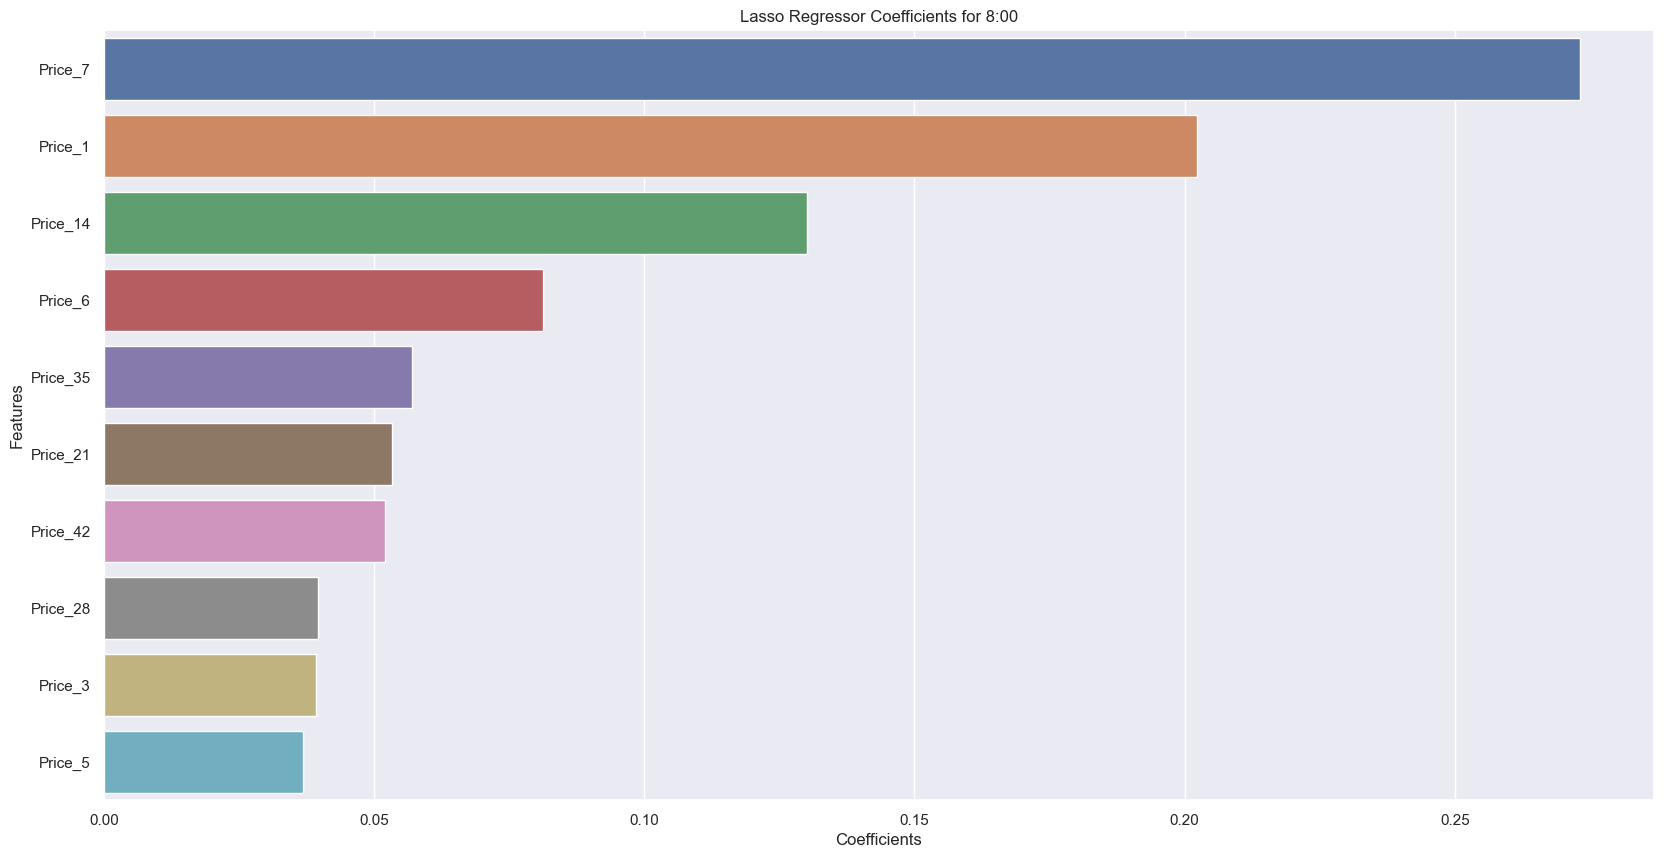

In [196]:
sns.barplot(x=a['Coefficients'],y=a.index )
plt.title('Lasso Regressor Coefficients for 8:00')
plt.ylabel('Features')
plt.xlabel('Coefficients')

In [197]:
lasso_1 = pd.DataFrame(columns=['Actual Value', 'Predicted Value', 'Residual', 'Squared Residuals'])
lasso_1['Actual Value'] = y[9]
lasso_1['Predicted Value'] = model[9].predict(X[9])
lasso_1['Residual'] = lasso_1['Actual Value'] - lasso_1['Predicted Value']
lasso_1['Squared Residuals'] = lasso_1['Residual'].mul(lasso_1['Residual'])

In [198]:
lasso = {hour: pd.DataFrame() for hour in hours}

for hour in hours:
    lasso[hour] = pd.DataFrame(columns=['Actual Value', 'Predicted Value', 'Residual', 'Squared Residuals'])
    lasso[hour]['Actual Value'] = y[hour]
    lasso[hour]['Predicted Value'] = model[hour].predict(X[hour])
    lasso[hour]['Residual'] = lasso[hour]['Actual Value'] - lasso[hour]['Predicted Value']
    lasso[hour]['Squared Residuals'] = lasso[hour]['Residual'].mul(lasso[hour]['Residual'])


In [199]:
lasso[15]

,Actual Value,Predicted Value,Residual,Squared Residuals
DateTime,,,,
2015-04-03 15:00:00,50.07,42.972363,7.097637,50.376456
2015-04-04 15:00:00,40.90,44.068806,-3.168806,10.041332
2015-04-05 15:00:00,41.58,41.387799,0.192201,0.036941
2015-04-06 15:00:00,40.00,41.051641,-1.051641,1.105950
2015-04-07 15:00:00,41.98,43.853951,-1.873951,3.511693
...,...,...,...,...
2020-12-27 15:00:00,50.70,44.858815,5.841185,34.119446
2020-12-28 15:00:00,48.19,53.959197,-5.769197,33.283635
2020-12-29 15:00:00,53.76,49.889941,3.870059,14.977355


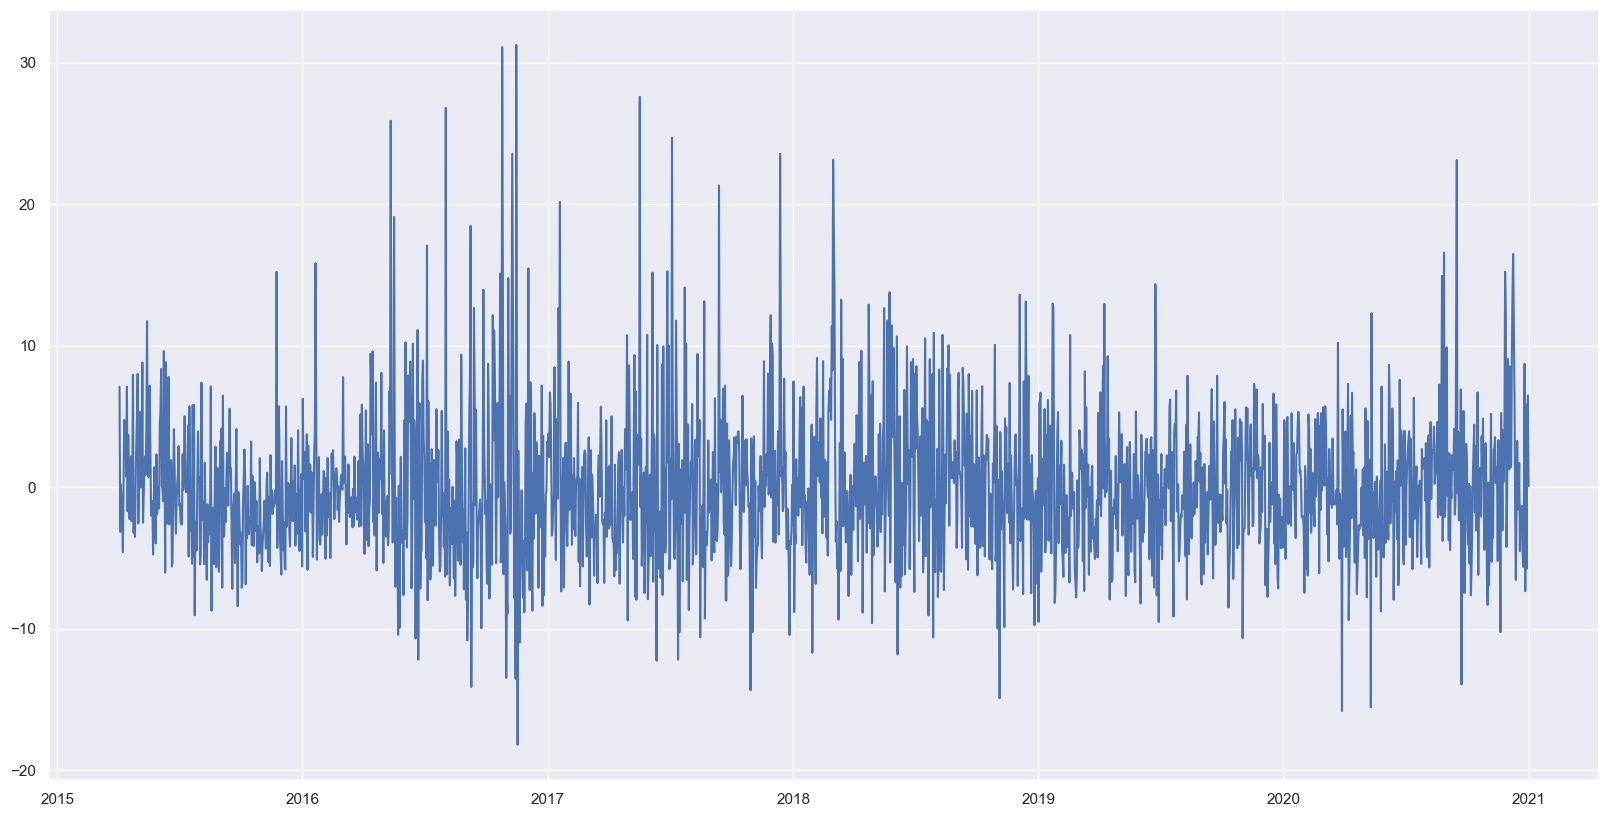

In [200]:
plt.plot(lasso[15]['Residual'])

## Garch Model

In [213]:
from arch import arch_model

arch_lasso_exp = arch_model(lasso[8]['Residual'], vol='GARCH', p=1,q=1, dist='t', mean='Constant')
arch_lasso_exp = arch_lasso_exp.fit()
arch_lasso_exp.summary()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 10462.941758488794
Iteration:      2,   Func. Count:     15,   Neg. LLF: 14074.930563843951
Iteration:      3,   Func. Count:     24,   Neg. LLF: 6798.027162631906
Iteration:      4,   Func. Count:     31,   Neg. LLF: 6753.06737982299
Iteration:      5,   Func. Count:     38,   Neg. LLF: 6751.900524245408
Iteration:      6,   Func. Count:     45,   Neg. LLF: 6751.351731263993
Iteration:      7,   Func. Count:     52,   Neg. LLF: 6741.650101998258
Iteration:      8,   Func. Count:     59,   Neg. LLF: 6739.5124872894785
Iteration:      9,   Func. Count:     66,   Neg. LLF: 6739.386806685103
Iteration:     10,   Func. Count:     72,   Neg. LLF: 6739.385304490126
Iteration:     11,   Func. Count:     78,   Neg. LLF: 6739.382490789516
Iteration:     12,   Func. Count:     84,   Neg. LLF: 6739.380589632732
Iteration:     13,   Func. Count:     90,   Neg. LLF: 6739.379819286163
Iteration:     14,   Func. Count:     96,   Neg. LLF: 6739.379

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                     Residual   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -6739.38
Distribution:      Standardized Student's t   AIC:                           13488.8
Method:                  Maximum Likelihood   BIC:                           13517.0
                                              No. Observations:                 2080
Date:                      Sun, Jan 22 2023   Df Residuals:                     2079
Time:                              13:38:43   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu            -0.1973      0.137     -1.441      0.149 [ -0.466,7.101e-02]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          1.8513      1.313      1.410      0.159   [ -0.723,  4.425]
alpha[1]       0.0645  2.430e-02      2.653  7.987e-03 [1.683e-02,  0.112]
beta[1]        0.8901  5.436e-02     16.375  2.892e-60   [  0.784,  0.997]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu            12.6923      2.957      4.292  1.773e-05 [  6.896, 18.489]
========================================================================

Covariance estimator: robust
"""

Text(0.5, 1.0, 'Volatility for 8:00')

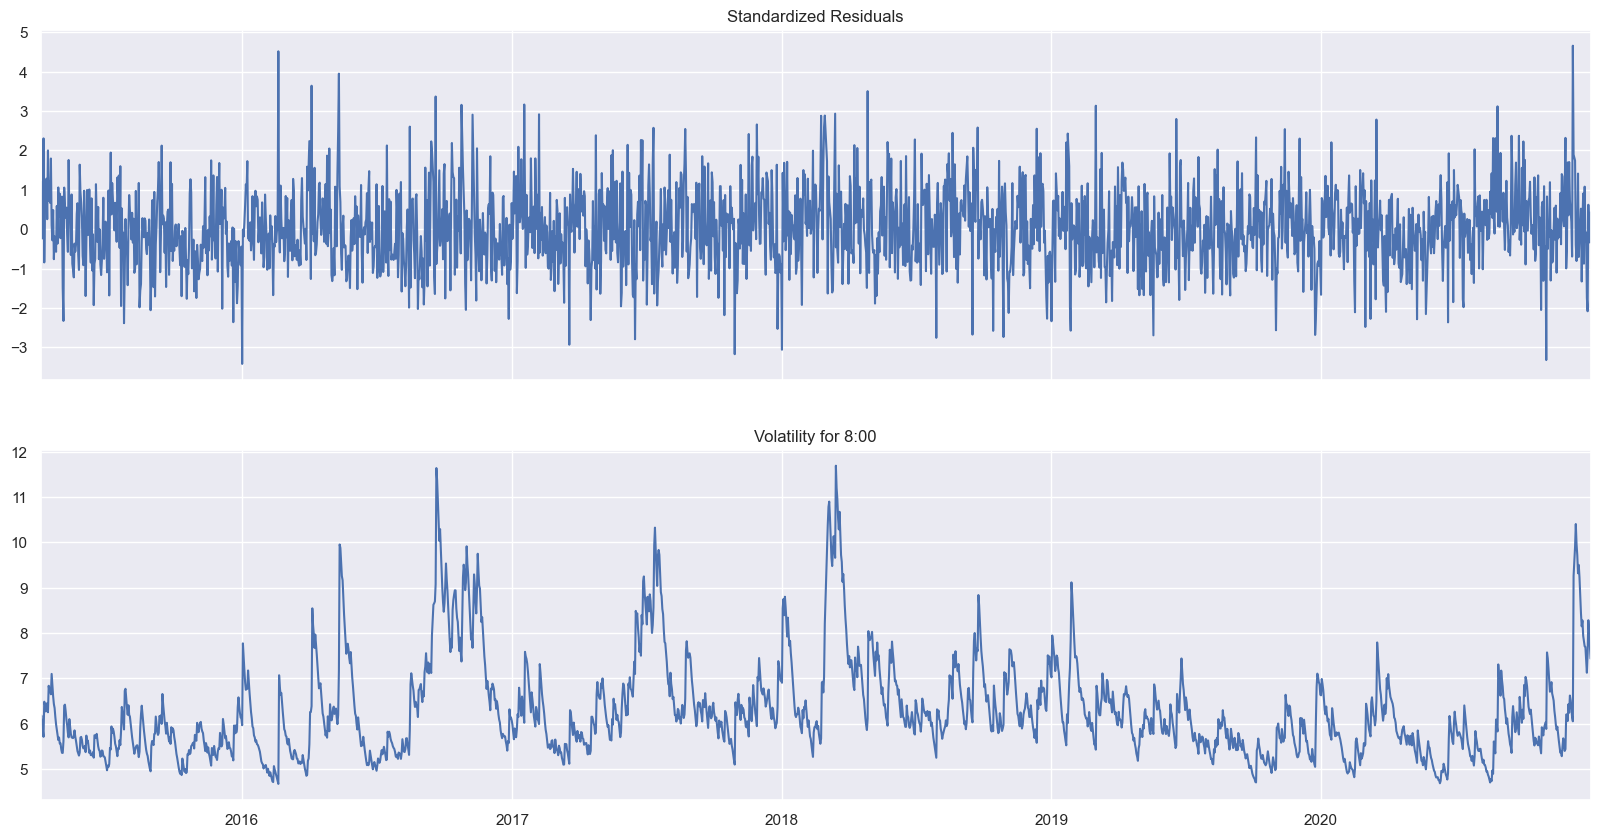

In [214]:
arch_lasso_exp.plot();
plt.title('Volatility for 8:00')


Text(0.5, 1.0, 'Distribution of Standardized Residuals for GARCH(1,1) - 8:00')

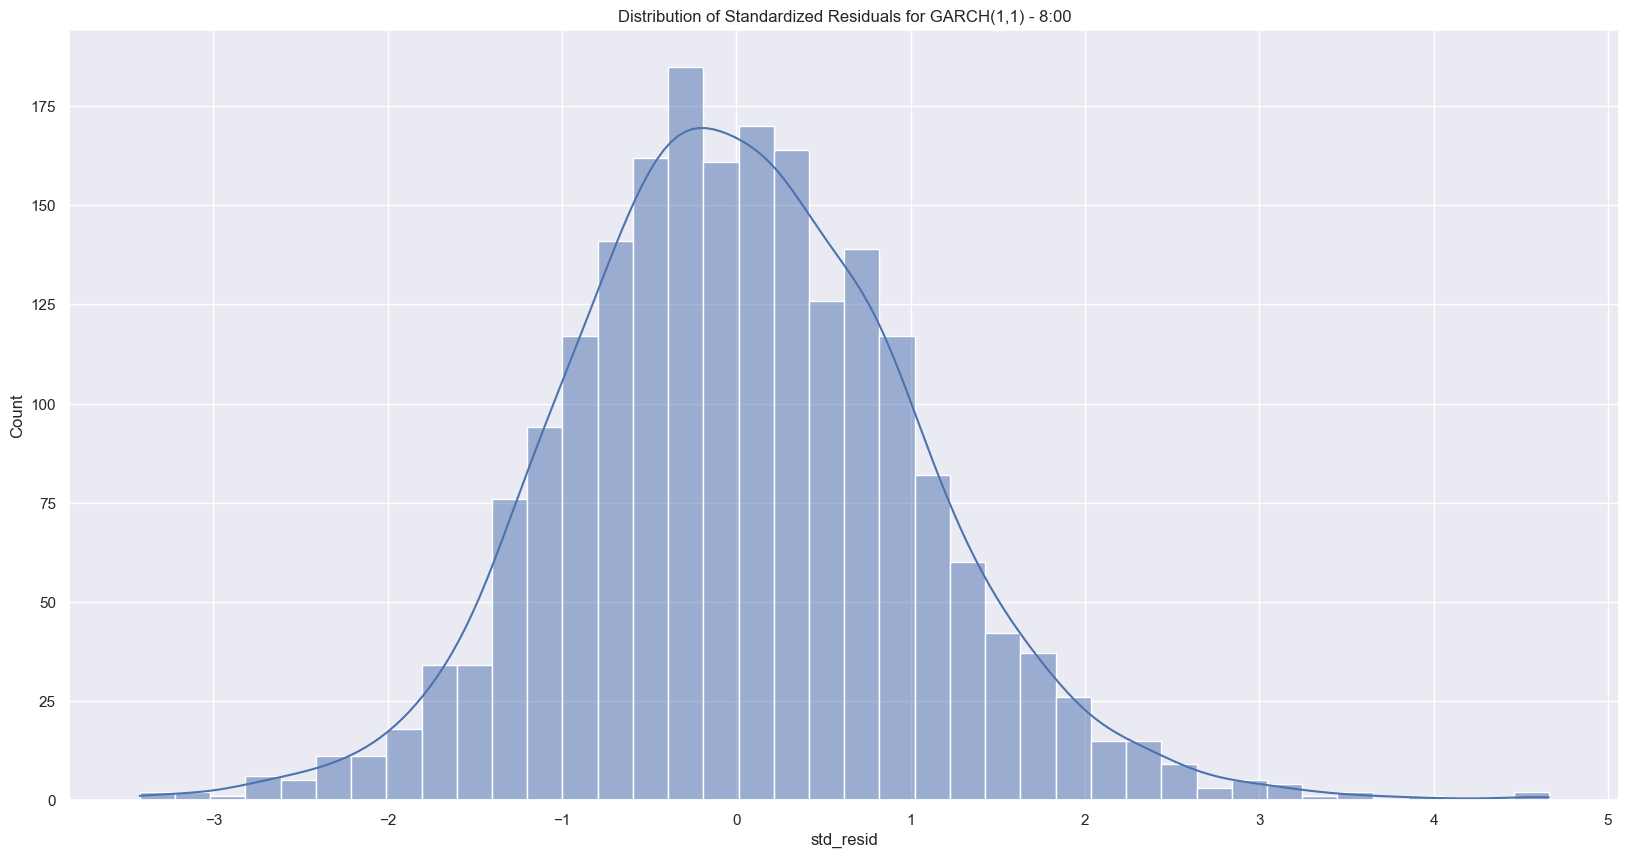

In [215]:
sns.histplot(arch_lasso_exp.std_resid, kde=True)
plt.title('Distribution of Standardized Residuals for GARCH(1,1) - 8:00')

Text(0.5, 1.0, 'QQplot for Standardized Residuals - GARCH(1,1) 8:00')

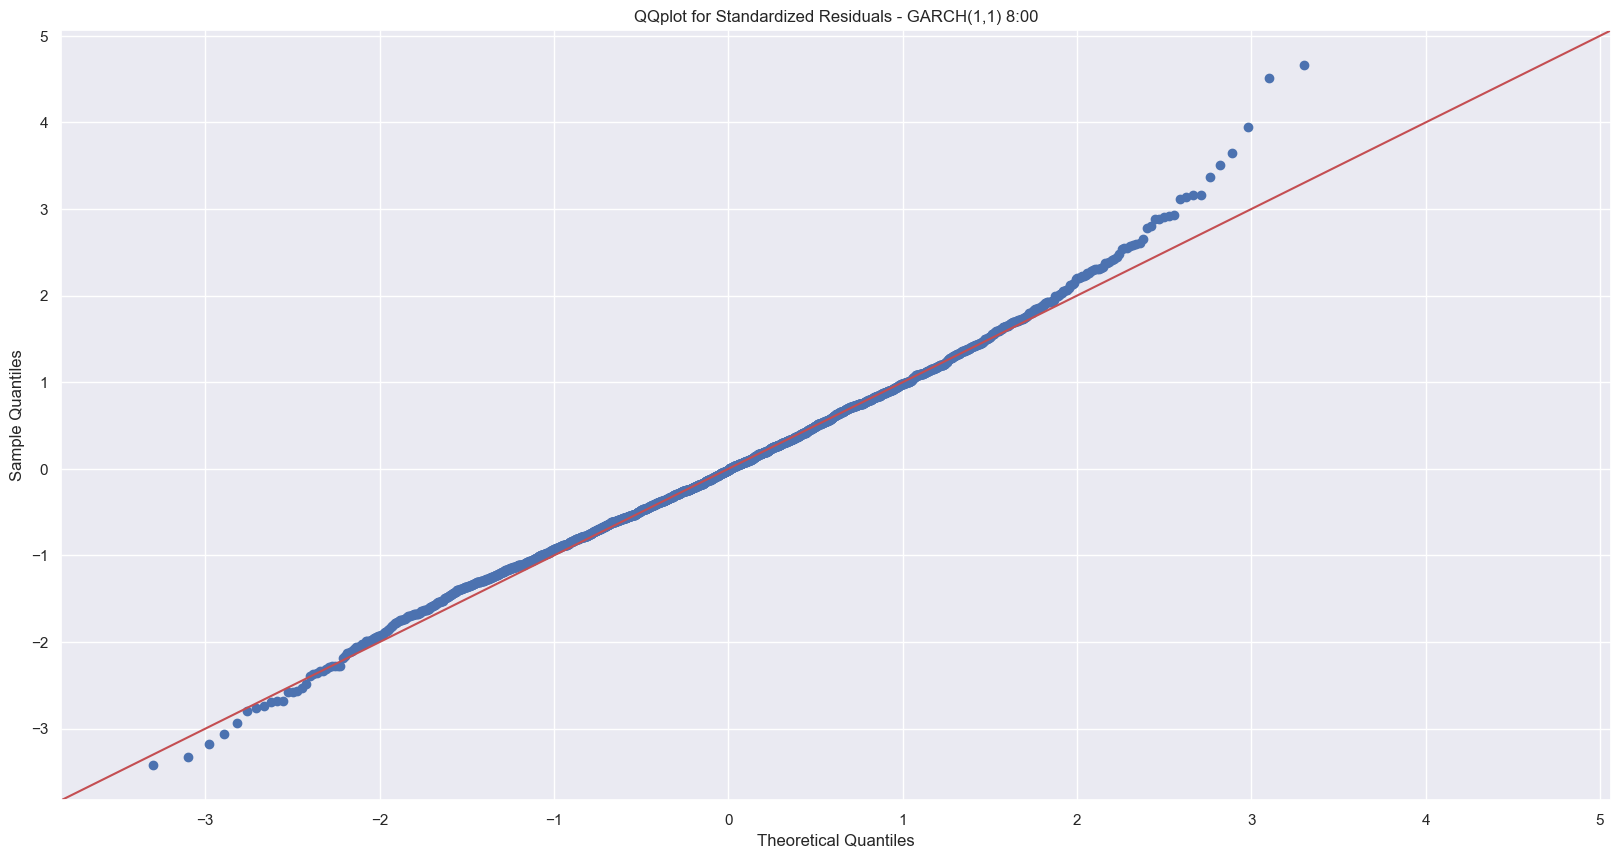

In [216]:
import statsmodels.api as sm
from scipy.stats import norm
import pylab

x = arch_lasso_exp.std_resid
sm.qqplot(x, line='45')

plt.title('QQplot for Standardized Residuals - GARCH(1,1) 8:00')

In [217]:
%%capture
from scipy import stats

model = []
pvalue = []
meanval = []
length_resid = []
Q1 = []
Q3 = []

for hour in hours:
    arch_lasso = arch_model(lasso[hour]['Residual'], vol='GARCH', p=1,q=1, dist='t', mean='Zero')
    arch_lasso = arch_lasso.fit()
    x = arch_lasso.std_resid
    stat_test = stats.kstest(x, "norm", alternative='less')
    q1 = np.quantile(x, .25)
    q3 = np.quantile(x, .75)
    model.append('Garch_Lasso['+str(hour)+']')
    pvalue.append(stat_test.pvalue)
    meanval.append(np.mean(x))
    length_resid.append(len(x))
    Q1.append(q1)
    Q3.append(q3)



In [218]:
df_arch_results = pd.DataFrame(columns=['Model', 'Pvalues for Normality', 'Mean', 'Sample Length', 'Q1', 'Q3'])
df_arch_results['Model'] = model
df_arch_results['Pvalues for Normality'] = pvalue
df_arch_results['Mean'] = meanval
df_arch_results['Sample Length'] = length_resid
df_arch_results['Q1'] = Q1
df_arch_results['Q3'] = Q3
df_arch_results

,Model,Pvalues for Normality,Mean,Sample Length,Q1,Q3
0,Garch_Lasso[0],0.000017,0.005468,2077,-0.580401,0.553550
1,Garch_Lasso[1],0.000044,-0.004928,2077,-0.553124,0.529403
2,Garch_Lasso[2],0.000205,-0.012627,2079,-0.550990,0.600315
3,Garch_Lasso[3],0.000004,-0.014836,2083,-0.518701,0.593434
4,Garch_Lasso[4],0.000001,-0.014354,2075,-0.510006,0.555079
5,Garch_Lasso[5],0.000035,-0.016984,2072,-0.556529,0.557533
6,Garch_Lasso[6],0.008173,-0.013291,2076,-0.590804,0.557401
7,Garch_Lasso[7],0.042731,-0.006113,2079,-0.636434,0.578733
8,Garch_Lasso[8],0.302311,-0.005740,2080,-0.658143,0.657826
9,Garch_Lasso[9],0.268157,-0.003954,2074,-0.683773,0.623554


In [219]:
from statsmodels.tsa.arima_process import ArmaProcess

ar = np.array([1, -0.9])
ma = np.array([1])

sim_step = []
mean = []
sd = []

for j in range(len(df_arch_results)):
    for i in range(0,1000):
        ar_factor = ArmaProcess(ar,ma)
        sim_data = ar_factor.generate_sample(nsample=df_arch_results.loc[j][3])
    sim_step.append('sim_arch_lasso_sample_' + str(j))
    mean.append(np.mean(sim_data))
    sd.append(np.std(sim_data))
        

df_simulation = pd.DataFrame(columns=['Simulation', 'Mean', 'SD'])
df_simulation['Simulation'] = sim_step
df_simulation['Mean'] = mean
df_simulation['SD'] = sd
df_simulation
df_compare = pd.concat([df_arch_results, df_simulation], axis="columns")

check = []

for i in range(len(df_compare)):
    if df_compare.iloc[i][7] >= df_compare.iloc[i][4] and df_compare.iloc[i][7] <= df_compare.iloc[i][5]:
        check.append('OK')
    else:
        check.append('NO')

df_compare['Test'] = check

In [220]:
df_compare

,Model,Pvalues for Normality,Mean,Sample Length,Q1,Q3,Simulation,Mean,SD,Test
0,Garch_Lasso[0],0.000017,0.005468,2077,-0.580401,0.553550,sim_arch_lasso_sample_0,-0.053183,2.160870,OK
1,Garch_Lasso[1],0.000044,-0.004928,2077,-0.553124,0.529403,sim_arch_lasso_sample_1,0.034836,2.489860,OK
2,Garch_Lasso[2],0.000205,-0.012627,2079,-0.550990,0.600315,sim_arch_lasso_sample_2,-0.053494,2.155508,OK
3,Garch_Lasso[3],0.000004,-0.014836,2083,-0.518701,0.593434,sim_arch_lasso_sample_3,-0.015805,2.097266,OK
4,Garch_Lasso[4],0.000001,-0.014354,2075,-0.510006,0.555079,sim_arch_lasso_sample_4,0.036761,2.086915,OK
5,Garch_Lasso[5],0.000035,-0.016984,2072,-0.556529,0.557533,sim_arch_lasso_sample_5,0.019436,2.332609,OK
6,Garch_Lasso[6],0.008173,-0.013291,2076,-0.590804,0.557401,sim_arch_lasso_sample_6,0.133979,2.113109,OK
7,Garch_Lasso[7],0.042731,-0.006113,2079,-0.636434,0.578733,sim_arch_lasso_sample_7,0.238356,2.089166,OK
8,Garch_Lasso[8],0.302311,-0.005740,2080,-0.658143,0.657826,sim_arch_lasso_sample_8,0.370124,2.479558,OK
9,Garch_Lasso[9],0.268157,-0.003954,2074,-0.683773,0.623554,sim_arch_lasso_sample_9,-0.065496,2.322316,OK


In [221]:
# df_compare.to_excel(r'C:\Users\2836589S\OneDrive - University of Glasgow\Data\garch_lasso_simulation.xlsx', index=False)

In [222]:
# lasso[8].to_excel(r'C:\Users\2836589S\OneDrive - University of Glasgow\Data\lasso8.xlsx', index=True)

In [223]:
# arch_lasso_exp.std_resid.to_csv(r'C:\Users\2836589S\OneDrive - University of Glasgow\Data\resid2016.csv')

In [224]:
# df_hour[8].to_excel(r'C:\Users\2836589S\OneDrive - University of Glasgow\Data\df_h_8.xlsx')